In [1]:
import pickle as pkl
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
from input_data import preprocess_data,load_sz_data,load_los_data
from tgcn import tgcnCell
from gru import GRUCell 

from visualization import plot_result,plot_error
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time

time_start = time.time()

###### Settings ######
flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('training_epoch', 2500, 'Number of epochs to train.')
flags.DEFINE_integer('gru_units', 100, 'hidden units of gru.')
flags.DEFINE_integer('seq_len', 5, 'time length of inputs.')
flags.DEFINE_integer('pre_len', 1, 'time length of prediction.')
flags.DEFINE_float('train_rate', 0.8, 'rate of training set.')
flags.DEFINE_integer('batch_size', 64, 'batch size.')
flags.DEFINE_string('dataset', '3611817550', 'sz or los.')
flags.DEFINE_string('model_name', 'TGCN_att', 'TGCN_att')
model_name = FLAGS.model_name
data_name = FLAGS.dataset
train_rate =  FLAGS.train_rate
seq_len = FLAGS.seq_len
output_dim = pre_len = FLAGS.pre_len
batch_size = FLAGS.batch_size
lr = FLAGS.learning_rate
training_epoch = FLAGS.training_epoch
gru_units = FLAGS.gru_units

###### load data ######
if data_name == '3611817550':
    data, adj = load_sz_data('3611817550')
if data_name == 'los':
    data, adj = load_los_data('los')

time_len = data.shape[0]
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32)
### Perturbation Analysis
#noise = np.random.normal(0,0.2,size=data.shape)
#noise = np.random.poisson(16,size=data.shape)
#scaler = MinMaxScaler()
#scaler.fit(noise)
#noise = scaler.transform(noise)
#data1 = data1 + noise
#### normalization
price_frame = data1
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
data1 = min_max_scaler.fit_transform(price_frame)
#max_value = np.max(data1)
max_value = 1
#data1  = data1/max_value

trainX, trainY, testX, testY = preprocess_data(data1, time_len, train_rate, seq_len, pre_len)

totalbatch = int(trainX.shape[0]/batch_size)
training_data_count = len(trainX)

def TGCN(_X, weights, biases):
    ###
    cell_1 = tgcnCell(gru_units, adj, num_nodes=num_nodes)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True)
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.nn.static_rnn(cell, _X, dtype=tf.float32)

    out = tf.concat(outputs, axis=0)
    out = tf.reshape(out, shape=[seq_len,-1,num_nodes,gru_units])
    out = tf.transpose(out, perm=[1,0,2,3])

    last_output,alpha = self_attention1(out, weight_att, bias_att)

    output = tf.reshape(last_output,shape=[-1,seq_len])
    output = tf.matmul(output, weights['out']) + biases['out']
    output = tf.reshape(output,shape=[-1,num_nodes,pre_len])
    output = tf.transpose(output, perm=[0,2,1])
    output = tf.reshape(output, shape=[-1,num_nodes])

    return output, outputs, states, alpha
    
def self_attention1(x, weight_att,bias_att):
    x = tf.matmul(tf.reshape(x,[-1,gru_units]),weight_att['w1']) + bias_att['b1']
#    f = tf.layers.conv2d(x, ch // 8, kernel_size=1, kernel_initializer=tf.variance_scaling_initializer())
    f = tf.matmul(tf.reshape(x, [-1, num_nodes]), weight_att['w2']) + bias_att['b2']
    g = tf.matmul(tf.reshape(x, [-1, num_nodes]), weight_att['w2']) + bias_att['b2']
    h = tf.matmul(tf.reshape(x, [-1, num_nodes]), weight_att['w2']) + bias_att['b2']

    f1 = tf.reshape(f, [-1,seq_len])
    g1 = tf.reshape(g, [-1,seq_len])
    h1 = tf.reshape(h, [-1,seq_len])
    s = g1 * f1
    print('s',s)

    beta = tf.nn.softmax(s, dim=-1)  # attention map
    print('bata',beta)
    context = tf.expand_dims(beta,2) * tf.reshape(x,[-1,seq_len,num_nodes])

    context = tf.transpose(context,perm=[0,2,1])
    print('context', context)
    return context, beta 
def self_attention(x, ch, weight_att, bias_att):
    f = tf.matmul(tf.reshape(x, [-1, gru_units]), weight_att['w'])
    g = tf.matmul(tf.reshape(x, [-1, gru_units]), weight_att['w']) + bias_att['b_att']
    h = tf.matmul(tf.reshape(x, [-1, gru_units]), weight_att['w']) + bias_att['b_att']
    print('h',h)

    f = tf.reshape(f, [-1,num_nodes])
    g = tf.reshape(g, [-1,num_nodes])
    h = tf.reshape(h, [-1,num_nodes])    
    s = g * f
    print('s',s)

    beta = tf.nn.softmax(s, dim=-1)  # attention map
    print('bata',beta)
#    o = tf.matmul(beta, h) # [bs, N, C]
    o = beta * h
    print('o',o)
    gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

#    o = tf.reshape(o, shape=x.shape) # [bs, h, w, C]
#    o = tf.reshape(o, shape=x.shape)
    o = tf.expand_dims(o, 2)
    x = gamma * o + x
    print('x',x)
#    x = tf.reduce_sum(x, 2)
    return x, beta    

###### placeholders ######
inputs = tf.placeholder(tf.float32, shape=[None, seq_len, num_nodes])
labels = tf.placeholder(tf.float32, shape=[None, pre_len, num_nodes])

# weights
weights = {
    'out': tf.Variable(tf.random_normal([seq_len, pre_len], mean=1.0), name='weight_o')}
bias = {
    'out': tf.Variable(tf.random_normal([pre_len]),name='bias_o')}
weight_att={
    'w1':tf.Variable(tf.random_normal([gru_units,1], stddev=0.1),name='att_w1'),
    'w2':tf.Variable(tf.random_normal([num_nodes,1], stddev=0.1),name='att_w2')}
bias_att = {
    'b1': tf.Variable(tf.random_normal([1]),name='att_b1'),
    'b2': tf.Variable(tf.random_normal([1]),name='att_b2')}

if model_name == 'TGCN_att':
    pred,ttto,ttts,alpha = TGCN(inputs, weights, bias)
#    print(alpha)
if model_name == 'GRU':
    pred,ttts,ttto = GRU(inputs, weights, bias)    
if model_name == 'GCN':
    model = GCN(gru_units, inputs, output_dim)
    
y_pred = pred
#print('ooooo',y_pred)
             

###### optimizer ######
lambda_loss = 0.0015
Lreg = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
label = tf.reshape(labels, [-1,num_nodes])
##loss
loss = tf.reduce_mean(tf.nn.l2_loss(y_pred-label) + Lreg)
##rmse
error = tf.sqrt(tf.reduce_mean(tf.square(y_pred-label)))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

###### Initialize session ######
variables = tf.global_variables()
saver = tf.train.Saver(tf.global_variables())  
#sess = tf.Session()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

#out = 'out/%s'%(model_name)
out = 'out/%s'%(model_name)
path1 = '%s_%s_lr%r_batch%r_unit%r_seq%r_pre%r_epoch%r'%(model_name,data_name,lr,batch_size,gru_units,seq_len,pre_len,training_epoch)
path = os.path.join(out,path1)
if not os.path.exists(path):
    os.makedirs(path)

s Tensor("mul:0", shape=(?, 5), dtype=float32)
bata Tensor("Softmax:0", shape=(?, 5), dtype=float32)
context Tensor("transpose_1:0", shape=(?, 30, 5), dtype=float32)


Iter:0 train_rmse:0.1666 test_loss:1.702e+03 test_rmse:9.517 test_acc:0.7032
Iter:1 train_rmse:0.1543 test_loss:1.446e+03 test_rmse:8.2 test_acc:0.7265
Iter:2 train_rmse:0.1173 test_loss:806.7 test_rmse:6.044 test_acc:0.7957
Iter:3 train_rmse:0.1032 test_loss:624.4 test_rmse:4.98 test_acc:0.8203
Iter:4 train_rmse:0.1001 test_loss:551.8 test_rmse:4.307 test_acc:0.8311
Iter:5 train_rmse:0.09422 test_loss:514.1 test_rmse:4.632 test_acc:0.837
Iter:6 train_rmse:0.08763 test_loss:446.1 test_rmse:4.289 test_acc:0.8482
Iter:7 train_rmse:0.08335 test_loss:399.1 test_rmse:4.045 test_acc:0.8564
Iter:8 train_rmse:0.07987 test_loss:375.3 test_rmse:4.153 test_acc:0.8607
Iter:9 train_rmse:0.07897 test_loss:342.4 test_rmse:3.323 test_acc:0.867
Iter:10 train_rmse:0.07245 test_loss:315.1 test_rmse:3.059 test_acc:0.8725
Iter:11 train_rmse:0.07062 test_loss:301.7 test_rmse:2.907 test_acc:0.8752
Iter:12 train_rmse:0.06936 test_loss:279.1 test_rmse:2.848 test_acc:0.88
Iter:13 train_rmse:0.06734 test_loss:26

Iter:110 train_rmse:0.045 test_loss:111.3 test_rmse:1.598 test_acc:0.9243
Iter:111 train_rmse:0.04432 test_loss:104.4 test_rmse:1.564 test_acc:0.9267
Iter:112 train_rmse:0.04429 test_loss:106.1 test_rmse:1.565 test_acc:0.9261
Iter:113 train_rmse:0.04481 test_loss:117.3 test_rmse:1.627 test_acc:0.9222
Iter:114 train_rmse:0.04464 test_loss:102.6 test_rmse:1.546 test_acc:0.9273
Iter:115 train_rmse:0.04549 test_loss:105.2 test_rmse:1.557 test_acc:0.9264
Iter:116 train_rmse:0.04505 test_loss:115.6 test_rmse:1.611 test_acc:0.9228
Iter:117 train_rmse:0.04365 test_loss:99.81 test_rmse:1.529 test_acc:0.9283
Iter:118 train_rmse:0.04364 test_loss:101.8 test_rmse:1.526 test_acc:0.9276
Iter:119 train_rmse:0.04394 test_loss:106.3 test_rmse:1.546 test_acc:0.926
Iter:120 train_rmse:0.04437 test_loss:114.7 test_rmse:1.599 test_acc:0.9231
Iter:121 train_rmse:0.04474 test_loss:117.4 test_rmse:1.616 test_acc:0.9222
Iter:122 train_rmse:0.04595 test_loss:134.3 test_rmse:1.739 test_acc:0.9168
Iter:123 train_

Iter:219 train_rmse:0.04061 test_loss:73.33 test_rmse:1.219 test_acc:0.9386
Iter:220 train_rmse:0.04039 test_loss:78.04 test_rmse:1.228 test_acc:0.9366
Iter:221 train_rmse:0.04094 test_loss:77.64 test_rmse:1.233 test_acc:0.9368
Iter:222 train_rmse:0.04101 test_loss:87.15 test_rmse:1.333 test_acc:0.933
Iter:223 train_rmse:0.04028 test_loss:87.77 test_rmse:1.344 test_acc:0.9328
Iter:224 train_rmse:0.0427 test_loss:97.3 test_rmse:1.468 test_acc:0.9292
Iter:225 train_rmse:0.04287 test_loss:96.42 test_rmse:1.454 test_acc:0.9295
Iter:226 train_rmse:0.04064 test_loss:98.15 test_rmse:1.498 test_acc:0.9289
Iter:227 train_rmse:0.04363 test_loss:96.73 test_rmse:1.447 test_acc:0.9294
Iter:228 train_rmse:0.04107 test_loss:87.85 test_rmse:1.322 test_acc:0.9327
Iter:229 train_rmse:0.04159 test_loss:97.35 test_rmse:1.448 test_acc:0.9292
Iter:230 train_rmse:0.04192 test_loss:91.36 test_rmse:1.359 test_acc:0.9314
Iter:231 train_rmse:0.04031 test_loss:89.31 test_rmse:1.328 test_acc:0.9322
Iter:232 train_

Iter:328 train_rmse:0.03896 test_loss:70.68 test_rmse:1.058 test_acc:0.9397
Iter:329 train_rmse:0.03896 test_loss:68.79 test_rmse:1.025 test_acc:0.9405
Iter:330 train_rmse:0.03983 test_loss:67.45 test_rmse:0.9939 test_acc:0.9411
Iter:331 train_rmse:0.03952 test_loss:67.36 test_rmse:1.001 test_acc:0.9411
Iter:332 train_rmse:0.03948 test_loss:67.5 test_rmse:1.0 test_acc:0.9411
Iter:333 train_rmse:0.0398 test_loss:67.57 test_rmse:1.004 test_acc:0.941
Iter:334 train_rmse:0.04002 test_loss:83.02 test_rmse:1.282 test_acc:0.9346
Iter:335 train_rmse:0.03969 test_loss:86.23 test_rmse:1.324 test_acc:0.9333
Iter:336 train_rmse:0.04047 test_loss:88.41 test_rmse:1.363 test_acc:0.9325
Iter:337 train_rmse:0.03981 test_loss:77.21 test_rmse:1.155 test_acc:0.9369
Iter:338 train_rmse:0.04706 test_loss:122.2 test_rmse:2.116 test_acc:0.9206
Iter:339 train_rmse:0.0389 test_loss:69.92 test_rmse:1.088 test_acc:0.94
Iter:340 train_rmse:0.03908 test_loss:69.34 test_rmse:1.089 test_acc:0.9403
Iter:341 train_rmse

Iter:436 train_rmse:0.03917 test_loss:64.72 test_rmse:0.9332 test_acc:0.9423
Iter:437 train_rmse:0.03876 test_loss:78.53 test_rmse:1.199 test_acc:0.9364
Iter:438 train_rmse:0.03906 test_loss:65.51 test_rmse:0.9386 test_acc:0.9419
Iter:439 train_rmse:0.03901 test_loss:67.42 test_rmse:0.9634 test_acc:0.9411
Iter:440 train_rmse:0.04028 test_loss:64.17 test_rmse:0.932 test_acc:0.9425
Iter:441 train_rmse:0.03897 test_loss:66.13 test_rmse:0.9496 test_acc:0.9416
Iter:442 train_rmse:0.03877 test_loss:66.23 test_rmse:0.9501 test_acc:0.9416
Iter:443 train_rmse:0.03887 test_loss:65.46 test_rmse:0.944 test_acc:0.9419
Iter:444 train_rmse:0.03993 test_loss:76.1 test_rmse:1.154 test_acc:0.9374
Iter:445 train_rmse:0.03961 test_loss:65.55 test_rmse:0.9392 test_acc:0.9419
Iter:446 train_rmse:0.03943 test_loss:66.05 test_rmse:0.9489 test_acc:0.9417
Iter:447 train_rmse:0.04139 test_loss:78.01 test_rmse:1.159 test_acc:0.9366
Iter:448 train_rmse:0.03927 test_loss:65.77 test_rmse:0.9432 test_acc:0.9418
Iter:

Iter:544 train_rmse:0.03995 test_loss:86.05 test_rmse:1.33 test_acc:0.9334
Iter:545 train_rmse:0.03842 test_loss:65.06 test_rmse:0.932 test_acc:0.9421
Iter:546 train_rmse:0.03854 test_loss:63.63 test_rmse:0.9182 test_acc:0.9428
Iter:547 train_rmse:0.03868 test_loss:62.92 test_rmse:0.9291 test_acc:0.9431
Iter:548 train_rmse:0.03875 test_loss:65.73 test_rmse:0.9372 test_acc:0.9418
Iter:549 train_rmse:0.03836 test_loss:63.71 test_rmse:0.9198 test_acc:0.9427
Iter:550 train_rmse:0.03848 test_loss:65.76 test_rmse:0.9404 test_acc:0.9418
Iter:551 train_rmse:0.03829 test_loss:75.72 test_rmse:1.12 test_acc:0.9375
Iter:552 train_rmse:0.03824 test_loss:64.1 test_rmse:0.922 test_acc:0.9425
Iter:553 train_rmse:0.03828 test_loss:72.05 test_rmse:1.064 test_acc:0.9391
Iter:554 train_rmse:0.03797 test_loss:64.27 test_rmse:0.9241 test_acc:0.9425
Iter:555 train_rmse:0.03838 test_loss:63.32 test_rmse:0.9154 test_acc:0.9429
Iter:556 train_rmse:0.03834 test_loss:63.94 test_rmse:0.9185 test_acc:0.9426
Iter:55

Iter:652 train_rmse:0.03794 test_loss:62.42 test_rmse:0.8973 test_acc:0.9433
Iter:653 train_rmse:0.03792 test_loss:62.11 test_rmse:0.8982 test_acc:0.9434
Iter:654 train_rmse:0.03774 test_loss:64.61 test_rmse:0.9268 test_acc:0.9423
Iter:655 train_rmse:0.03764 test_loss:62.84 test_rmse:0.9007 test_acc:0.9431
Iter:656 train_rmse:0.0377 test_loss:69.11 test_rmse:1.005 test_acc:0.9403
Iter:657 train_rmse:0.03787 test_loss:62.38 test_rmse:0.9007 test_acc:0.9433
Iter:658 train_rmse:0.03772 test_loss:66.91 test_rmse:0.9659 test_acc:0.9413
Iter:659 train_rmse:0.039 test_loss:75.74 test_rmse:1.157 test_acc:0.9375
Iter:660 train_rmse:0.0383 test_loss:61.98 test_rmse:0.9038 test_acc:0.9435
Iter:661 train_rmse:0.03761 test_loss:66.93 test_rmse:0.9612 test_acc:0.9413
Iter:662 train_rmse:0.03761 test_loss:62.26 test_rmse:0.899 test_acc:0.9434
Iter:663 train_rmse:0.03769 test_loss:62.79 test_rmse:0.9006 test_acc:0.9431
Iter:664 train_rmse:0.03794 test_loss:61.81 test_rmse:0.9135 test_acc:0.9436
Iter:6

Iter:760 train_rmse:0.03794 test_loss:67.27 test_rmse:0.9821 test_acc:0.9411
Iter:761 train_rmse:0.03976 test_loss:82.17 test_rmse:1.28 test_acc:0.9349
Iter:762 train_rmse:0.03733 test_loss:64.81 test_rmse:0.9344 test_acc:0.9422
Iter:763 train_rmse:0.03806 test_loss:69.33 test_rmse:1.032 test_acc:0.9402
Iter:764 train_rmse:0.03776 test_loss:67.99 test_rmse:0.9898 test_acc:0.9408
Iter:765 train_rmse:0.03823 test_loss:70.82 test_rmse:1.06 test_acc:0.9396
Iter:766 train_rmse:0.03865 test_loss:76.06 test_rmse:1.158 test_acc:0.9374
Iter:767 train_rmse:0.03793 test_loss:68.85 test_rmse:1.016 test_acc:0.9404
Iter:768 train_rmse:0.03748 test_loss:64.55 test_rmse:0.9287 test_acc:0.9423
Iter:769 train_rmse:0.03852 test_loss:61.34 test_rmse:0.8814 test_acc:0.9438
Iter:770 train_rmse:0.03793 test_loss:69.84 test_rmse:1.045 test_acc:0.94
Iter:771 train_rmse:0.03938 test_loss:79.53 test_rmse:1.233 test_acc:0.936
Iter:772 train_rmse:0.03895 test_loss:71.66 test_rmse:1.073 test_acc:0.9392
Iter:773 tra

Iter:868 train_rmse:0.03768 test_loss:66.7 test_rmse:0.9847 test_acc:0.9414
Iter:869 train_rmse:0.038 test_loss:66.77 test_rmse:0.9852 test_acc:0.9413
Iter:870 train_rmse:0.03715 test_loss:64.49 test_rmse:0.9365 test_acc:0.9423
Iter:871 train_rmse:0.03765 test_loss:66.72 test_rmse:0.9831 test_acc:0.9413
Iter:872 train_rmse:0.03713 test_loss:64.73 test_rmse:0.9453 test_acc:0.9422
Iter:873 train_rmse:0.03733 test_loss:64.57 test_rmse:0.9367 test_acc:0.9423
Iter:874 train_rmse:0.03759 test_loss:65.15 test_rmse:0.9473 test_acc:0.942
Iter:875 train_rmse:0.03808 test_loss:65.79 test_rmse:0.9592 test_acc:0.9418
Iter:876 train_rmse:0.03828 test_loss:66.51 test_rmse:0.9816 test_acc:0.9414
Iter:877 train_rmse:0.03734 test_loss:65.88 test_rmse:0.9651 test_acc:0.9417
Iter:878 train_rmse:0.03751 test_loss:66.83 test_rmse:0.9846 test_acc:0.9413
Iter:879 train_rmse:0.03753 test_loss:66.31 test_rmse:0.9767 test_acc:0.9415
Iter:880 train_rmse:0.03741 test_loss:67.64 test_rmse:1.002 test_acc:0.9409
Iter

Iter:976 train_rmse:0.03693 test_loss:63.26 test_rmse:0.9024 test_acc:0.9429
Iter:977 train_rmse:0.03701 test_loss:62.77 test_rmse:0.8969 test_acc:0.9431
Iter:978 train_rmse:0.0375 test_loss:64.21 test_rmse:0.9253 test_acc:0.9425
Iter:979 train_rmse:0.03718 test_loss:63.78 test_rmse:0.9197 test_acc:0.9427
Iter:980 train_rmse:0.03688 test_loss:62.18 test_rmse:0.8919 test_acc:0.9434
Iter:981 train_rmse:0.0373 test_loss:63.96 test_rmse:0.9151 test_acc:0.9426
Iter:982 train_rmse:0.03663 test_loss:63.7 test_rmse:0.9262 test_acc:0.9427
Iter:983 train_rmse:0.03661 test_loss:66.01 test_rmse:0.9605 test_acc:0.9417
Iter:984 train_rmse:0.03663 test_loss:64.44 test_rmse:0.9363 test_acc:0.9424
Iter:985 train_rmse:0.03662 test_loss:62.98 test_rmse:0.9026 test_acc:0.943
Iter:986 train_rmse:0.03662 test_loss:60.17 test_rmse:0.8734 test_acc:0.9443
Iter:987 train_rmse:0.03674 test_loss:62.03 test_rmse:0.8831 test_acc:0.9435
Iter:988 train_rmse:0.03669 test_loss:60.58 test_rmse:0.8692 test_acc:0.9441
Ite

Iter:1083 train_rmse:0.03797 test_loss:62.97 test_rmse:0.9419 test_acc:0.943
Iter:1084 train_rmse:0.03824 test_loss:63.54 test_rmse:0.9491 test_acc:0.9428
Iter:1085 train_rmse:0.03806 test_loss:62.32 test_rmse:0.9382 test_acc:0.9433
Iter:1086 train_rmse:0.03825 test_loss:62.79 test_rmse:0.9453 test_acc:0.9431
Iter:1087 train_rmse:0.03866 test_loss:62.07 test_rmse:0.9121 test_acc:0.9434
Iter:1088 train_rmse:0.03851 test_loss:63.15 test_rmse:0.9342 test_acc:0.9429
Iter:1089 train_rmse:0.03866 test_loss:62.29 test_rmse:0.9291 test_acc:0.9433
Iter:1090 train_rmse:0.03747 test_loss:63.66 test_rmse:0.9528 test_acc:0.9427
Iter:1091 train_rmse:0.03785 test_loss:63.29 test_rmse:0.9454 test_acc:0.9429
Iter:1092 train_rmse:0.0384 test_loss:65.56 test_rmse:0.9867 test_acc:0.9419
Iter:1093 train_rmse:0.03907 test_loss:63.52 test_rmse:0.9401 test_acc:0.9428
Iter:1094 train_rmse:0.03728 test_loss:61.69 test_rmse:0.9081 test_acc:0.9436
Iter:1095 train_rmse:0.03885 test_loss:63.15 test_rmse:0.9344 test

Iter:1189 train_rmse:0.03644 test_loss:62.38 test_rmse:0.9067 test_acc:0.9433
Iter:1190 train_rmse:0.03635 test_loss:62.08 test_rmse:0.8784 test_acc:0.9434
Iter:1191 train_rmse:0.03639 test_loss:62.06 test_rmse:0.8799 test_acc:0.9434
Iter:1192 train_rmse:0.03639 test_loss:62.06 test_rmse:0.8865 test_acc:0.9434
Iter:1193 train_rmse:0.03655 test_loss:62.91 test_rmse:0.8972 test_acc:0.943
Iter:1194 train_rmse:0.03639 test_loss:62.0 test_rmse:0.8857 test_acc:0.9435
Iter:1195 train_rmse:0.03651 test_loss:62.42 test_rmse:0.8948 test_acc:0.9433
Iter:1196 train_rmse:0.03651 test_loss:62.08 test_rmse:0.8818 test_acc:0.9434
Iter:1197 train_rmse:0.03636 test_loss:62.34 test_rmse:0.8822 test_acc:0.9433
Iter:1198 train_rmse:0.03647 test_loss:63.4 test_rmse:0.9184 test_acc:0.9428
Iter:1199 train_rmse:0.03646 test_loss:62.3 test_rmse:0.8895 test_acc:0.9433
Iter:1200 train_rmse:0.03635 test_loss:62.14 test_rmse:0.8756 test_acc:0.9434
Iter:1201 train_rmse:0.03637 test_loss:62.26 test_rmse:0.8854 test_a

Iter:1295 train_rmse:0.03647 test_loss:59.05 test_rmse:0.854 test_acc:0.9448
Iter:1296 train_rmse:0.03638 test_loss:59.03 test_rmse:0.8508 test_acc:0.9448
Iter:1297 train_rmse:0.03644 test_loss:59.06 test_rmse:0.8566 test_acc:0.9448
Iter:1298 train_rmse:0.03643 test_loss:59.45 test_rmse:0.8602 test_acc:0.9446
Iter:1299 train_rmse:0.03638 test_loss:59.29 test_rmse:0.8688 test_acc:0.9447
Iter:1300 train_rmse:0.03643 test_loss:59.55 test_rmse:0.8642 test_acc:0.9446
Iter:1301 train_rmse:0.03648 test_loss:59.28 test_rmse:0.8567 test_acc:0.9447
Iter:1302 train_rmse:0.03639 test_loss:59.07 test_rmse:0.8532 test_acc:0.9448
Iter:1303 train_rmse:0.03644 test_loss:59.11 test_rmse:0.8542 test_acc:0.9448
Iter:1304 train_rmse:0.03636 test_loss:59.03 test_rmse:0.8465 test_acc:0.9448
Iter:1305 train_rmse:0.03648 test_loss:58.9 test_rmse:0.86 test_acc:0.9449
Iter:1306 train_rmse:0.03644 test_loss:59.17 test_rmse:0.8528 test_acc:0.9448
Iter:1307 train_rmse:0.03638 test_loss:59.14 test_rmse:0.8636 test_a

Iter:1401 train_rmse:0.03617 test_loss:58.83 test_rmse:0.8755 test_acc:0.9449
Iter:1402 train_rmse:0.03622 test_loss:58.55 test_rmse:0.8622 test_acc:0.9451
Iter:1403 train_rmse:0.03628 test_loss:58.77 test_rmse:0.8793 test_acc:0.945
Iter:1404 train_rmse:0.03617 test_loss:58.62 test_rmse:0.8632 test_acc:0.945
Iter:1405 train_rmse:0.03607 test_loss:58.76 test_rmse:0.8575 test_acc:0.945
Iter:1406 train_rmse:0.03622 test_loss:58.71 test_rmse:0.8555 test_acc:0.945
Iter:1407 train_rmse:0.0362 test_loss:58.73 test_rmse:0.8552 test_acc:0.945
Iter:1408 train_rmse:0.03616 test_loss:58.64 test_rmse:0.8528 test_acc:0.945
Iter:1409 train_rmse:0.03625 test_loss:58.55 test_rmse:0.8598 test_acc:0.9451
Iter:1410 train_rmse:0.03626 test_loss:58.63 test_rmse:0.8637 test_acc:0.945
Iter:1411 train_rmse:0.03614 test_loss:58.88 test_rmse:0.8855 test_acc:0.9449
Iter:1412 train_rmse:0.03626 test_loss:58.59 test_rmse:0.872 test_acc:0.945
Iter:1413 train_rmse:0.03616 test_loss:58.56 test_rmse:0.8621 test_acc:0.9

Iter:1508 train_rmse:0.03604 test_loss:58.7 test_rmse:0.8565 test_acc:0.945
Iter:1509 train_rmse:0.03599 test_loss:58.65 test_rmse:0.8596 test_acc:0.945
Iter:1510 train_rmse:0.03598 test_loss:58.63 test_rmse:0.8806 test_acc:0.945
Iter:1511 train_rmse:0.03604 test_loss:58.41 test_rmse:0.8751 test_acc:0.9451
Iter:1512 train_rmse:0.03606 test_loss:58.58 test_rmse:0.8624 test_acc:0.945
Iter:1513 train_rmse:0.03602 test_loss:58.47 test_rmse:0.8576 test_acc:0.9451
Iter:1514 train_rmse:0.03607 test_loss:58.67 test_rmse:0.8466 test_acc:0.945
Iter:1515 train_rmse:0.03604 test_loss:58.33 test_rmse:0.8554 test_acc:0.9452
Iter:1516 train_rmse:0.03617 test_loss:58.36 test_rmse:0.8593 test_acc:0.9451
Iter:1517 train_rmse:0.03604 test_loss:58.6 test_rmse:0.8597 test_acc:0.945
Iter:1518 train_rmse:0.03603 test_loss:58.64 test_rmse:0.8599 test_acc:0.945
Iter:1519 train_rmse:0.0361 test_loss:58.17 test_rmse:0.8474 test_acc:0.9452
Iter:1520 train_rmse:0.03605 test_loss:58.34 test_rmse:0.8597 test_acc:0.9

Iter:1614 train_rmse:0.03597 test_loss:57.99 test_rmse:0.8493 test_acc:0.9453
Iter:1615 train_rmse:0.03598 test_loss:58.77 test_rmse:0.8605 test_acc:0.9449
Iter:1616 train_rmse:0.03601 test_loss:58.58 test_rmse:0.856 test_acc:0.945
Iter:1617 train_rmse:0.03605 test_loss:58.5 test_rmse:0.8412 test_acc:0.9451
Iter:1618 train_rmse:0.03609 test_loss:58.76 test_rmse:0.8618 test_acc:0.945
Iter:1619 train_rmse:0.03603 test_loss:58.42 test_rmse:0.8574 test_acc:0.9451
Iter:1620 train_rmse:0.03599 test_loss:58.36 test_rmse:0.8614 test_acc:0.9451
Iter:1621 train_rmse:0.03591 test_loss:58.34 test_rmse:0.8486 test_acc:0.9452
Iter:1622 train_rmse:0.036 test_loss:58.16 test_rmse:0.8486 test_acc:0.9452
Iter:1623 train_rmse:0.03601 test_loss:58.35 test_rmse:0.8507 test_acc:0.9451
Iter:1624 train_rmse:0.03594 test_loss:58.48 test_rmse:0.8577 test_acc:0.9451
Iter:1625 train_rmse:0.036 test_loss:58.31 test_rmse:0.8455 test_acc:0.9452
Iter:1626 train_rmse:0.03605 test_loss:58.23 test_rmse:0.8506 test_acc:0

Iter:1720 train_rmse:0.03606 test_loss:58.03 test_rmse:0.8613 test_acc:0.9453
Iter:1721 train_rmse:0.03612 test_loss:57.83 test_rmse:0.8467 test_acc:0.9454
Iter:1722 train_rmse:0.03645 test_loss:57.81 test_rmse:0.8601 test_acc:0.9454
Iter:1723 train_rmse:0.03655 test_loss:57.79 test_rmse:0.8682 test_acc:0.9454
Iter:1724 train_rmse:0.03643 test_loss:57.77 test_rmse:0.8654 test_acc:0.9454
Iter:1725 train_rmse:0.0362 test_loss:57.7 test_rmse:0.8679 test_acc:0.9455
Iter:1726 train_rmse:0.03626 test_loss:57.71 test_rmse:0.8541 test_acc:0.9454
Iter:1727 train_rmse:0.03635 test_loss:57.83 test_rmse:0.8578 test_acc:0.9454
Iter:1728 train_rmse:0.0363 test_loss:57.75 test_rmse:0.8647 test_acc:0.9454
Iter:1729 train_rmse:0.03651 test_loss:58.09 test_rmse:0.8949 test_acc:0.9453
Iter:1730 train_rmse:0.03643 test_loss:59.79 test_rmse:0.9692 test_acc:0.9445
Iter:1731 train_rmse:0.03637 test_loss:57.99 test_rmse:0.8468 test_acc:0.9453
Iter:1732 train_rmse:0.03647 test_loss:58.41 test_rmse:0.9135 test_

Iter:1826 train_rmse:0.03638 test_loss:57.31 test_rmse:0.8452 test_acc:0.9456
Iter:1827 train_rmse:0.03637 test_loss:57.78 test_rmse:0.8847 test_acc:0.9454
Iter:1828 train_rmse:0.03636 test_loss:57.6 test_rmse:0.8818 test_acc:0.9455
Iter:1829 train_rmse:0.03628 test_loss:57.6 test_rmse:0.8834 test_acc:0.9455
Iter:1830 train_rmse:0.03628 test_loss:57.26 test_rmse:0.8431 test_acc:0.9457
Iter:1831 train_rmse:0.03625 test_loss:57.28 test_rmse:0.849 test_acc:0.9457
Iter:1832 train_rmse:0.03628 test_loss:57.73 test_rmse:0.8829 test_acc:0.9454
Iter:1833 train_rmse:0.03641 test_loss:59.2 test_rmse:0.9577 test_acc:0.9447
Iter:1834 train_rmse:0.03629 test_loss:57.18 test_rmse:0.8381 test_acc:0.9457
Iter:1835 train_rmse:0.03619 test_loss:59.22 test_rmse:0.9606 test_acc:0.9447
Iter:1836 train_rmse:0.03644 test_loss:57.39 test_rmse:0.8504 test_acc:0.9456
Iter:1837 train_rmse:0.03623 test_loss:61.68 test_rmse:1.054 test_acc:0.9436
Iter:1838 train_rmse:0.03625 test_loss:57.65 test_rmse:0.8773 test_ac

Iter:1932 train_rmse:0.0361 test_loss:57.16 test_rmse:0.859 test_acc:0.9457
Iter:1933 train_rmse:0.03605 test_loss:59.84 test_rmse:0.9816 test_acc:0.9444
Iter:1934 train_rmse:0.03592 test_loss:61.08 test_rmse:1.042 test_acc:0.9439
Iter:1935 train_rmse:0.03636 test_loss:57.41 test_rmse:0.8662 test_acc:0.9456
Iter:1936 train_rmse:0.03607 test_loss:58.16 test_rmse:0.9142 test_acc:0.9452
Iter:1937 train_rmse:0.03598 test_loss:59.37 test_rmse:0.9596 test_acc:0.9447
Iter:1938 train_rmse:0.03621 test_loss:57.89 test_rmse:0.8931 test_acc:0.9454
Iter:1939 train_rmse:0.0363 test_loss:56.79 test_rmse:0.8175 test_acc:0.9459
Iter:1940 train_rmse:0.03621 test_loss:59.52 test_rmse:0.962 test_acc:0.9446
Iter:1941 train_rmse:0.03582 test_loss:60.98 test_rmse:1.025 test_acc:0.9439
Iter:1942 train_rmse:0.03618 test_loss:56.9 test_rmse:0.8397 test_acc:0.9458
Iter:1943 train_rmse:0.03637 test_loss:58.04 test_rmse:0.9031 test_acc:0.9453
Iter:1944 train_rmse:0.03621 test_loss:58.96 test_rmse:0.9375 test_acc:

Iter:2038 train_rmse:0.03591 test_loss:58.41 test_rmse:0.9176 test_acc:0.9451
Iter:2039 train_rmse:0.03612 test_loss:57.16 test_rmse:0.838 test_acc:0.9457
Iter:2040 train_rmse:0.03622 test_loss:57.35 test_rmse:0.8518 test_acc:0.9456
Iter:2041 train_rmse:0.03609 test_loss:57.19 test_rmse:0.8269 test_acc:0.9457
Iter:2042 train_rmse:0.03596 test_loss:58.53 test_rmse:0.9172 test_acc:0.9451
Iter:2043 train_rmse:0.03615 test_loss:57.41 test_rmse:0.8497 test_acc:0.9456
Iter:2044 train_rmse:0.03585 test_loss:58.83 test_rmse:0.9314 test_acc:0.9449
Iter:2045 train_rmse:0.03587 test_loss:58.22 test_rmse:0.9058 test_acc:0.9452
Iter:2046 train_rmse:0.03575 test_loss:59.25 test_rmse:0.9569 test_acc:0.9447
Iter:2047 train_rmse:0.03614 test_loss:57.72 test_rmse:0.8798 test_acc:0.9454
Iter:2048 train_rmse:0.03581 test_loss:57.69 test_rmse:0.8783 test_acc:0.9455
Iter:2049 train_rmse:0.03598 test_loss:57.88 test_rmse:0.8812 test_acc:0.9454
Iter:2050 train_rmse:0.03608 test_loss:57.19 test_rmse:0.8484 tes

Iter:2144 train_rmse:0.03618 test_loss:56.71 test_rmse:0.8004 test_acc:0.9459
Iter:2145 train_rmse:0.03597 test_loss:56.98 test_rmse:0.8238 test_acc:0.9458
Iter:2146 train_rmse:0.03595 test_loss:56.66 test_rmse:0.7955 test_acc:0.9459
Iter:2147 train_rmse:0.03612 test_loss:57.48 test_rmse:0.845 test_acc:0.9456
Iter:2148 train_rmse:0.0362 test_loss:57.65 test_rmse:0.8165 test_acc:0.9455
Iter:2149 train_rmse:0.03603 test_loss:57.28 test_rmse:0.8359 test_acc:0.9456
Iter:2150 train_rmse:0.03612 test_loss:56.84 test_rmse:0.8093 test_acc:0.9459
Iter:2151 train_rmse:0.03608 test_loss:57.11 test_rmse:0.8263 test_acc:0.9457
Iter:2152 train_rmse:0.03598 test_loss:56.98 test_rmse:0.8297 test_acc:0.9458
Iter:2153 train_rmse:0.03576 test_loss:57.11 test_rmse:0.7701 test_acc:0.9457
Iter:2154 train_rmse:0.03597 test_loss:56.69 test_rmse:0.7595 test_acc:0.9459
Iter:2155 train_rmse:0.03602 test_loss:57.05 test_rmse:0.818 test_acc:0.9458
Iter:2156 train_rmse:0.03578 test_loss:56.57 test_rmse:0.7741 test_

Iter:2250 train_rmse:0.03581 test_loss:56.47 test_rmse:0.7539 test_acc:0.946
Iter:2251 train_rmse:0.03595 test_loss:56.33 test_rmse:0.7619 test_acc:0.9461
Iter:2252 train_rmse:0.036 test_loss:56.2 test_rmse:0.7386 test_acc:0.9462
Iter:2253 train_rmse:0.03598 test_loss:56.57 test_rmse:0.7372 test_acc:0.946
Iter:2254 train_rmse:0.03611 test_loss:56.6 test_rmse:0.7436 test_acc:0.946
Iter:2255 train_rmse:0.03603 test_loss:56.27 test_rmse:0.742 test_acc:0.9461
Iter:2256 train_rmse:0.03612 test_loss:56.48 test_rmse:0.7403 test_acc:0.946
Iter:2257 train_rmse:0.03598 test_loss:56.13 test_rmse:0.7196 test_acc:0.9462
Iter:2258 train_rmse:0.03586 test_loss:56.23 test_rmse:0.7379 test_acc:0.9461
Iter:2259 train_rmse:0.03577 test_loss:56.99 test_rmse:0.7357 test_acc:0.9458
Iter:2260 train_rmse:0.03608 test_loss:56.34 test_rmse:0.7405 test_acc:0.9461
Iter:2261 train_rmse:0.03593 test_loss:56.15 test_rmse:0.7265 test_acc:0.9462
Iter:2262 train_rmse:0.03603 test_loss:56.27 test_rmse:0.7575 test_acc:0.

Iter:2356 train_rmse:0.03576 test_loss:55.71 test_rmse:0.7105 test_acc:0.9464
Iter:2357 train_rmse:0.03567 test_loss:56.35 test_rmse:0.7194 test_acc:0.9461
Iter:2358 train_rmse:0.03558 test_loss:56.38 test_rmse:0.7186 test_acc:0.9461
Iter:2359 train_rmse:0.03572 test_loss:55.84 test_rmse:0.7172 test_acc:0.9463
Iter:2360 train_rmse:0.0357 test_loss:56.05 test_rmse:0.7142 test_acc:0.9462
Iter:2361 train_rmse:0.03569 test_loss:56.41 test_rmse:0.7199 test_acc:0.9461
Iter:2362 train_rmse:0.03588 test_loss:56.01 test_rmse:0.7137 test_acc:0.9463
Iter:2363 train_rmse:0.03576 test_loss:56.13 test_rmse:0.707 test_acc:0.9462
Iter:2364 train_rmse:0.0357 test_loss:56.29 test_rmse:0.7298 test_acc:0.9461
Iter:2365 train_rmse:0.03587 test_loss:55.73 test_rmse:0.7157 test_acc:0.9464
Iter:2366 train_rmse:0.03567 test_loss:55.94 test_rmse:0.703 test_acc:0.9463
Iter:2367 train_rmse:0.03576 test_loss:55.76 test_rmse:0.7104 test_acc:0.9464
Iter:2368 train_rmse:0.03591 test_loss:55.86 test_rmse:0.7152 test_a

Iter:2462 train_rmse:0.0365 test_loss:62.35 test_rmse:0.8205 test_acc:0.9433
Iter:2463 train_rmse:0.03616 test_loss:58.54 test_rmse:0.8252 test_acc:0.945
Iter:2464 train_rmse:0.03602 test_loss:57.36 test_rmse:0.7811 test_acc:0.9456
Iter:2465 train_rmse:0.03623 test_loss:60.67 test_rmse:0.8352 test_acc:0.9441
Iter:2466 train_rmse:0.0362 test_loss:61.02 test_rmse:0.8451 test_acc:0.9439
Iter:2467 train_rmse:0.0362 test_loss:62.76 test_rmse:0.8708 test_acc:0.9431
Iter:2468 train_rmse:0.03597 test_loss:58.21 test_rmse:0.7708 test_acc:0.9452
Iter:2469 train_rmse:0.03565 test_loss:64.26 test_rmse:0.8471 test_acc:0.9424
Iter:2470 train_rmse:0.03611 test_loss:62.92 test_rmse:0.8444 test_acc:0.943
Iter:2471 train_rmse:0.03597 test_loss:60.82 test_rmse:0.8653 test_acc:0.944
Iter:2472 train_rmse:0.03609 test_loss:61.5 test_rmse:0.8603 test_acc:0.9437
Iter:2473 train_rmse:0.03561 test_loss:64.18 test_rmse:0.8468 test_acc:0.9425
Iter:2474 train_rmse:0.03554 test_loss:61.09 test_rmse:0.8008 test_acc:

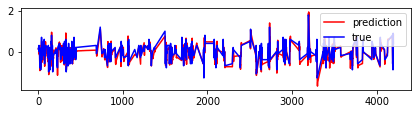

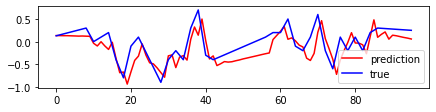

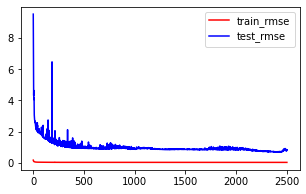

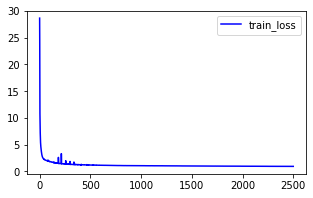

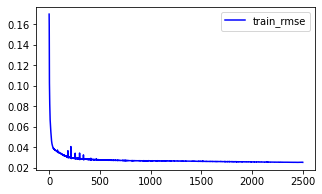

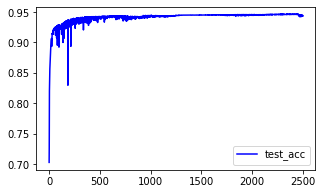

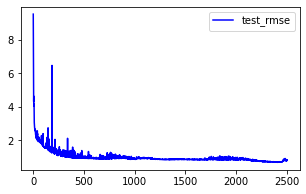

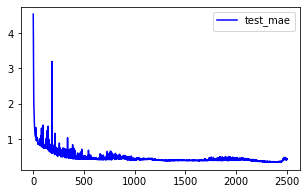

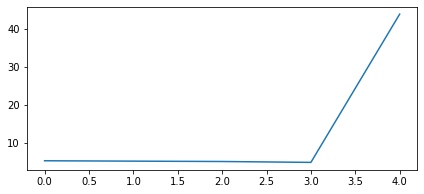

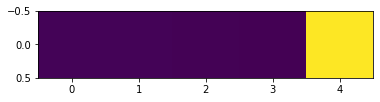

model_name: TGCN_att
min_rmse:0.6819947642631583 min_mae:0.34399685 max_acc:0.9463253207504749 r2:0.9704916682094336 var:0.9706319011747837


In [2]:
###### evaluation ######
def evaluation1(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    return rmse, mae
def evaluation2(a,b):
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return 1-F_norm, r2, var

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s
    

x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred = [],[],[],[],[],[],[]
test_no_renor_pred = []
for epoch in range(training_epoch):
    for m in range(totalbatch):
        mini_batch = trainX[m * batch_size : (m+1) * batch_size]
        mini_label = trainY[m * batch_size : (m+1) * batch_size]
        _, loss1, rmse1, train_output, alpha1 = sess.run([optimizer, loss, error, y_pred, alpha],
                                                 feed_dict = {inputs:mini_batch, labels:mini_label})
        batch_loss.append(loss1)
        batch_rmse.append(rmse1 * max_value)

     # Test completely at every epoch
    loss2, rmse2, test_output = sess.run([loss, error, y_pred],
                                         feed_dict = {inputs:testX, labels:testY})
    
    testoutput = np.abs(test_output)
    test_label = np.reshape(testY,[-1,num_nodes])
    
# ############## normalization ###############
#     price_frame = pd.DataFrame(pd.read_excel(r'./data_35-5_under10float/3611817550_feature_matrix_X.xlsx', header=0))
#     min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
#     x_minmax = min_max_scaler.fit_transform(price_frame)
    
    acc, r2_score, var_score = evaluation2(test_label, testoutput)
    
############## renormalization ###############  
#     test_label1 = test_label * max_value
#     test_output1 = testoutput * max_value
    test_label1 = min_max_scaler.inverse_transform(test_label)
    test_output1 = min_max_scaler.inverse_transform(testoutput)
    
    rmse, mae = evaluation1(test_label1, test_output1)
    test_loss.append(loss2)
#     test_rmse.append(rmse * max_value)
#     test_mae.append(mae * max_value)
    test_rmse.append(rmse)
    test_mae.append(mae)
    test_acc.append(acc)
    test_r2.append(r2_score)
    test_var.append(var_score)
    test_pred.append(test_output1)
    test_no_renor_pred.append(testoutput)
    
    
    print('Iter:{}'.format(epoch),
          'train_rmse:{:.4}'.format(batch_rmse[-1]),
          'test_loss:{:.4}'.format(loss2),
          'test_rmse:{:.4}'.format(rmse),
          'test_acc:{:.4}'.format(acc))
    
    if (epoch % 500 == 0):        
        saver.save(sess, path+'/model_100/graphGRU_pre_%r'%epoch, global_step = epoch)
        
time_end = time.time()
print(time_end-time_start,'s')

############## visualization ###############
#x = [i for i in range(training_epoch)]
b = int(len(batch_rmse)/totalbatch)
batch_rmse1 = [i for i in batch_rmse]
train_rmse = [(sum(batch_rmse1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
batch_loss1 = [i for i in batch_loss]
train_loss = [(sum(batch_loss1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
#test_rmse = [float(i) for i in test_rmse]
# var = pd.DataFrame(batch_loss1)
# var.to_csv(path+'/batch_loss.csv',index = False,header = False)
# var = pd.DataFrame(train_loss)
# var.to_csv(path+'/train_loss.csv',index = False,header = False)
# var = pd.DataFrame(batch_rmse1)
# var.to_csv(path+'/batch_rmse.csv',index = False,header = False)
# var = pd.DataFrame(train_rmse)
# var.to_csv(path+'/train_rmse.csv',index = False,header = False)
# var = pd.DataFrame(test_loss)
# var.to_csv(path+'/test_loss.csv',index = False,header = False)
# var = pd.DataFrame(test_acc)
# var.to_csv(path+'/test_acc.csv',index = False,header = False)
# var = pd.DataFrame(test_rmse)
# var.to_csv(path+'/test_rmse.csv',index = False,header = False)


index = test_rmse.index(np.min(test_rmse))
test_result = test_pred[index]
test_no_renor_pred = test_no_renor_pred[index]
var = pd.DataFrame(test_result)
var2 = pd.DataFrame(test_label1)
var.to_csv(path+'/test_prediction.csv',index = False,header = False)
var2.to_csv(path+'/test_true.csv',index = False,header = False)
plot_result(test_result,test_label1,path)
plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path)

fig1 = plt.figure(figsize=(7,3))
ax1 = fig1.add_subplot(1,1,1)
plt.plot(np.sum(alpha1,0))
plt.savefig(path+'/alpha.jpg',dpi=500)
plt.show()


plt.imshow(np.mat(np.sum(alpha1,0)))
plt.savefig(path+'/alpha11.jpg',dpi=500)
plt.show()

evalution = []
evalution.append(np.min(test_rmse))
evalution.append(test_mae[index])
evalution.append(test_acc[index])
evalution.append(test_r2[index])
evalution.append(test_var[index])
evalution = pd.DataFrame(evalution)
evalution.to_csv(path+'/evalution_all.csv',index=False,header=None)


print('model_name:', model_name)
print('min_rmse:%r'%(np.min(test_rmse)),
      'min_mae:%r'%(test_mae[index]),
      'max_acc:%r'%(test_acc[index]),
      'r2:%r'%(test_r2[index]),
      'var:%r'%test_var[index])